# Roman Urdu Hate Speech Classification

Hate Speech is a specific type of content that is widely considered as a crime and it must be identified and blocked. But in todays world where there is so much data coming from social media it is difficult to perform the detection manually. To solve this problem many researchers are conducting studies and implementing algorithms for European or English languages.
But little attention is paid to solve the issue of hate speech detection in low resource south asian language, and almost no or very less study is carried out for roman urdu text. 
So in this notebook I will implement algorithm using the power of artificial intelligence to classify hate speech tweets.

# Loading Libraries

In [4]:
import pandas as pd # To read dataset in dataframe style
import numpy as np # To perform mathematical computations
import tensorflow as tf # To Implement Neural Networks
import re # Regular Expression
import matplotlib.pyplot as plt # For Visualization
import seaborn as sns # For visualization
from bs4 import BeautifulSoup # To remove html tags
import unicodedata # To remove accented characters
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold

## Loading Dataset

Dataset: https://github.com/haroonshakeel/roman_urdu_hate_speech

I have downloaded the dataset from the mentioned link of github.

Labels are distributed as follow

Abusive Tweet: 0 <br>
Neutral Tweet: 1

In [5]:
df = pd.read_csv('/content/Roman_Urdu_Hate_Speech_Dataset.csv',usecols=['Tweet','Label'], index_col=False)

### Viewing the first 5 tweets from the dataset

In [6]:
df.head()

,Tweet,Label
0,pichwara se akhrot kahe fod rahe ho chicha,1
1,bhaunk bhaunk ke pagal ho jaata ab tak....,0
2,shivsaina nam mulla saina rakh hijra uddh...,0
3,there are some yahodi daboo like imran chore z...,0
4,"chutiye ye hunduism ni he islam he , isme koi ...",0


### Viewing the last 5 tweets from the dataset

In [7]:
df.tail()

,Tweet,Label
9207,ap kese ko gali dyne se phale soch lia karo jo...,1
9208,madarboard saali,0
9209,frog naseem use to represent mqm in baldia fir...,0
9210,tou khud ko bchi samjti hy saali 😂😂😂😂😂,0
9211,rt : bhenchod how to stop using 😂😂✋,0


# Utility Functions

#### Getting Basic Features from Dataset

##### Word Counts

In [8]:
def get_wordcounts(x):
  # This function inputs a string
  # Returns the length of the string
	length = len(str(x).split())
	return length

##### Character Counts

In [9]:
def get_charcounts(x):
  # This function inputs a string
  # Returns the character count in the string
	s = x.split()
	x = ''.join(s)
	return len(x)

##### Average words in tweets

In [10]:
def get_avg_wordlength(x):
  # This function inputs a string
  # Returns the Average words lenght
  # formulae is total character in a string / total words
	count = get_charcounts(x)/get_wordcounts(x)
	return count

##### Hash tag count

In [11]:
def get_hashtag_counts(x):
  # This function input a string 
  # And returns the total hashtags in the string
  # Because our data is mostly focused on tweets
  # So for EDA it is important to know the hasttag counts
	l = len([t for t in x.split() if t.startswith('#')])
	return l

##### Mention Count

In [12]:
def get_mentions_counts(x):
  # This function inputs a string
  # Returns the mention to other users in the tweet
	l = len([t for t in x.split() if t.startswith('@')])
	return l

##### Digit Counts

In [13]:
def get_digit_counts(x):
  # This function inputs a string 
  # Return the digits in a string
  # important in EDA to know if the tweets contain
  # numbers like phone numbers etc.
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

In [14]:
def get_basic_features(df,col):
  df['char_counts'] = df[col].apply(lambda x: get_charcounts(x))
  df['word_counts'] = df[col].apply(lambda x: get_wordcounts(x))
  df['avg_wordlength'] = df[col].apply(lambda x: get_avg_wordlength(x))
  df['hashtag_counts'] = df[col].apply(lambda x: get_hashtag_counts(x))
  df['mentions_counts'] = df[col].apply(lambda x: get_mentions_counts(x))
  df['digits_counts'] = df[col].apply(lambda x: get_digit_counts(x))
  return df

#### Data Cleaning

##### Remove emails

In [15]:
def remove_emails(x):
	return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

##### Remove url links

In [16]:
def remove_urls(x):
	return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

##### Remove html tags

In [17]:
def remove_html_tags(x):
	return BeautifulSoup(x, 'lxml').get_text().strip()

##### Remove retweets

In [18]:
def remove_rt(x):
	return re.sub(r'\brt\b', '', x).strip()

##### Remove accented characters 

In [19]:
def remove_accented_chars(x):
	x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
	return x

##### Remove special characters like emojies

In [20]:
def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

In [21]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = remove_emails(x)
    x = remove_urls(x)
    x = remove_html_tags(x)
    x = remove_rt(x)
    x = remove_accented_chars(x)
    x = remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

# Exploratory Data Analysis

In [22]:
df_for_eda = get_basic_features(df,col='Tweet')

In [23]:
df_for_eda.head()

,Tweet,Label,char_counts,word_counts,avg_wordlength,hashtag_counts,mentions_counts,digits_counts
0,pichwara se akhrot kahe fod rahe ho chicha,1,35,8,4.375000,0,0,0
1,bhaunk bhaunk ke pagal ho jaata ab tak....,0,35,8,4.375000,0,0,1
2,shivsaina nam mulla saina rakh hijra uddh...,0,46,8,5.750000,0,0,0
3,there are some yahodi daboo like imran chore z...,0,47,10,4.700000,0,0,0
4,"chutiye ye hunduism ni he islam he , isme koi ...",0,69,18,3.833333,0,0,1


In [24]:
# To plot using matplotlib 
# Let us define some parameters
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.dpi'] = 120

### Target Class Distribution

So from the figure below we can say that our target class distribution is almost balanced. 
There are 4921 tweets which are neutral and 4291 tweets are related to Abusive/Offensive in our dataset

In [25]:
df_for_eda['Label'].value_counts()

1    4921
0    4291
Name: Label, dtype: int64

#### Bar Plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


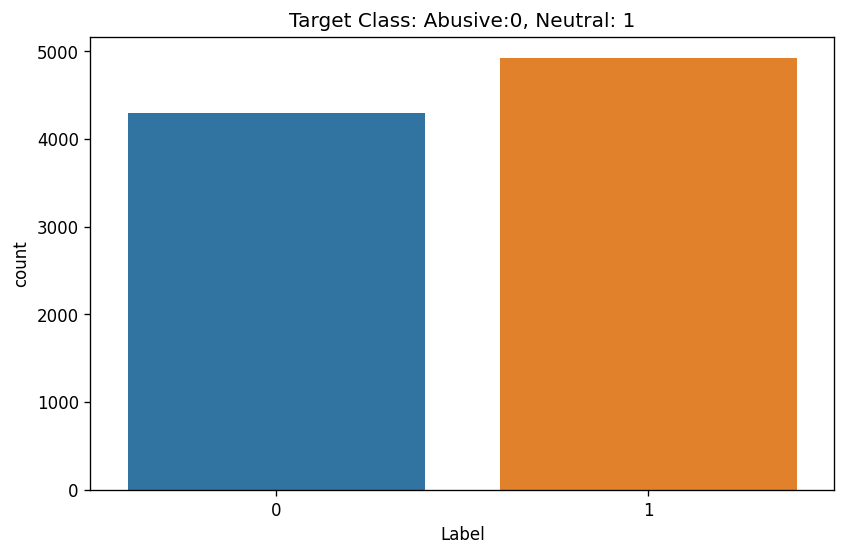

In [26]:
sns.countplot('Label',data=df_for_eda)
plt.title('Target Class: Abusive:0, Neutral: 1')
plt.show()

#### Pie Chart

53.42% tweets are neutral <br>
46.58% tweets are Abusive/offensive

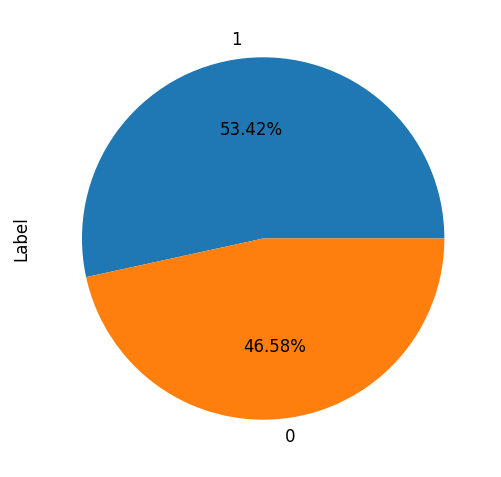

In [27]:
df_for_eda['Label'].value_counts().plot.pie(autopct='%1.2f%%')

### Characters Distribution

Let us plot a total number of character distribution 

The longest tweet is **325** character long.

In [28]:
df_for_eda['char_counts'].max()

325

Smallest tweet in the dataset is only **5** character long

In [29]:
df_for_eda['char_counts'].min()

5

Average number of characters in tweets are almost **70** characters.

In [30]:
df_for_eda['char_counts'].mean()

69.38992618323925

From the figure we can analyze that most of the tweets in the datasets are 40-80 characters long. Because there is a high peak in the distribution plot in the interval

#### Distribution plot

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


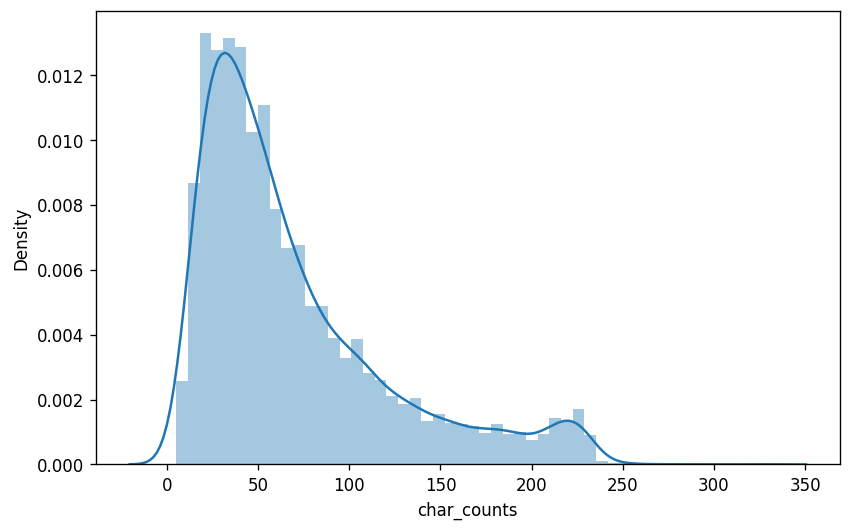

In [31]:
sns.distplot(df_for_eda['char_counts'])

#### Kernel density plot

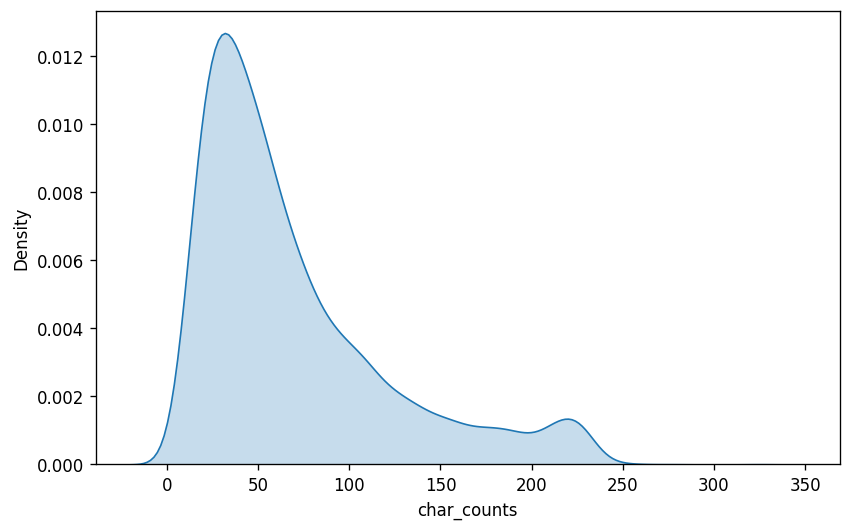

In [32]:
sns.kdeplot(df_for_eda['char_counts'],shade=True)

### Characters Distribution according to Label

We can analyze from the plot that Abusive tweets are usually short in lenght according to total characters and neutral tweets have higher number of characters as compared to abusive tweets

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


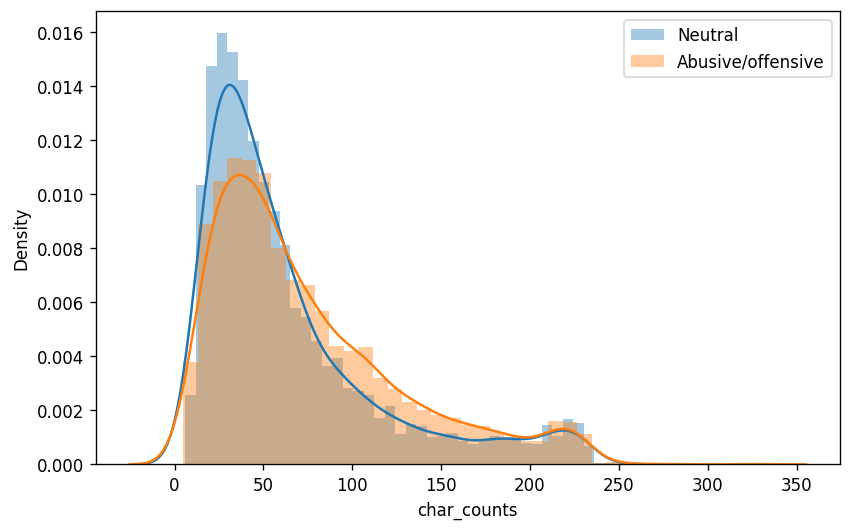

In [33]:
sns.distplot(df_for_eda[df_for_eda['Label']==1]['char_counts'],label='Neutral')
sns.distplot(df_for_eda[df_for_eda['Label']==0]['char_counts'],label='Abusive/offensive')
plt.legend()
plt.show()

#### Violin plot according to target class

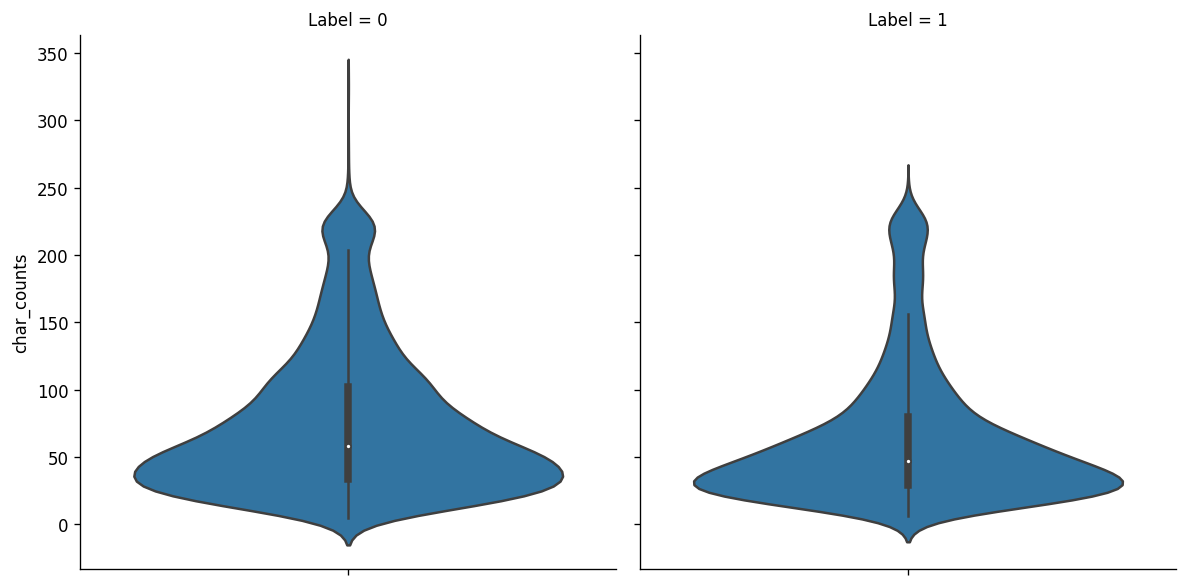

In [34]:
sns.catplot(y='char_counts',data=df_for_eda,kind='violin',col='Label')

### Number of Words Distribution

In [35]:
df_for_eda.columns

Index(['Tweet', 'Label', 'char_counts', 'word_counts', 'avg_wordlength',
       'hashtag_counts', 'mentions_counts', 'digits_counts'],
      dtype='object')

#### Kernel distribution plot for total word counts in tweets

We can analyze from the eda according to word length of the tweet that longest tweet in the dataset is 71 words long and shortest tweet is consist on only 1 word. Average number of words in a tweet is 17 words.


In [36]:
print(f"Longest tweet consist on {df_for_eda['word_counts'].max()} words")

Longest tweet consist on 71 words


In [37]:
print(f"Shortest tweet consist on {df_for_eda['word_counts'].min()} words")

Shortest tweet consist on 1 words


In [38]:
print(f"Average tweet Length {df_for_eda['word_counts'].mean()} words")

Average tweet Length 17.067412071211464 words


From the figure we can induce that neutral tweets contain more words than the offensive tweets but also we can say that most of tweets in both classes contain around 10-20 words because plot is more dense in this span as compared to other spans

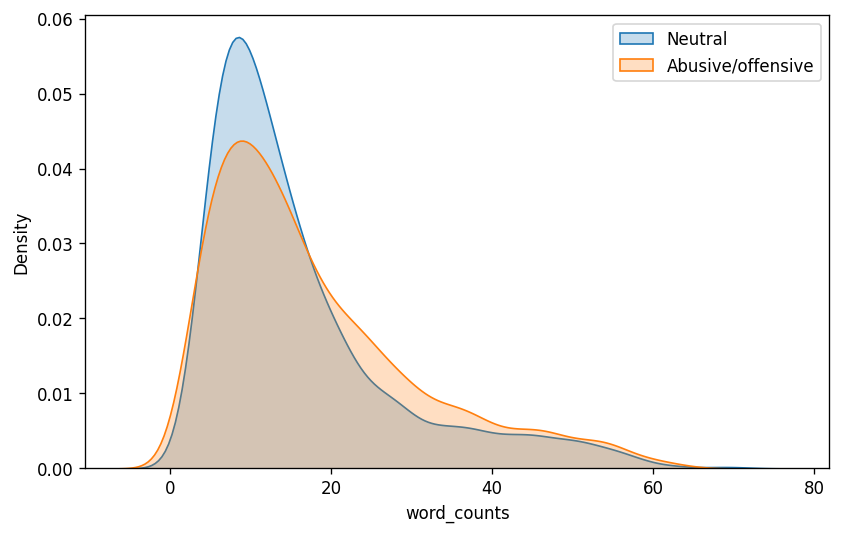

In [39]:
sns.kdeplot(df_for_eda[df_for_eda['Label']==1]['word_counts'],label='Neutral',shade=True)
sns.kdeplot(df_for_eda[df_for_eda['Label']==0]['word_counts'],label='Abusive/offensive',shade=True)
plt.legend()
plt.show()

### Data Preprocessing (Cleaning and Removing StopWords)

In [40]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### Removing stop words from The Data

In [41]:
stopwords_roman_urdu = { "roman_urdu_stop_words": 
    [
        "ai", "ayi", "hy", "hai", "main", "ki", "tha", "koi", "ko", "sy", "woh", 
        "bhi", "aur", "wo", "yeh", "rha", "hota", "ho", "ga", "ka", "le", "lye", 
        "kr", "kar", "lye", "liye", "hotay", "waisay", "gya", "gaya", "kch", "ab",
        "thy", "thay", "houn", "hain", "han", "to", "is", "hi", "jo", "kya", "thi",
        "se", "pe", "phr", "wala", "waisay", "us", "na", "ny", "hun", "rha", "raha",
        "ja", "rahay", "abi", "uski", "ne", "haan", "acha", "nai", "sent", "photo", 
        "you", "kafi", "gai", "rhy", "kuch", "jata", "aye", "ya", "dono", "hoa", 
        "aese", "de", "wohi", "jati", "jb", "krta", "lg", "rahi", "hui", "karna", 
        "krna", "gi", "hova", "yehi", "jana", "jye", "chal", "mil", "tu", "hum", "par", 
        "hay", "kis", "sb", "gy", "dain", "krny", "tou"
    ]
}

In [42]:
ls_stopwords = stopwords_roman_urdu['roman_urdu_stop_words']

In [43]:
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize

all_stopwords_gensim = STOPWORDS.union(set(ls_stopwords))

def remove_stop_words(text):
  text_tokens = word_tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in all_stopwords_gensim]
  tokens_without_sw = ' '.join(tokens_without_sw)
  return tokens_without_sw

##### Removing stopwords from the tweets

In [44]:
df_for_eda['clean_tweet'] = df_for_eda['Tweet'].apply(lambda x: remove_stop_words(x))

##### Cleaning of the tweet data from unwanted strings

In [45]:
df_for_eda['clean_tweet'] = df_for_eda['clean_tweet'].apply(lambda x: get_clean(x))

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [46]:
df_for_eda.head(10)

,Tweet,Label,char_counts,word_counts,avg_wordlength,hashtag_counts,mentions_counts,digits_counts,clean_tweet
0,pichwara se akhrot kahe fod rahe ho chicha,1,35,8,4.375000,0,0,0,pichwara akhrot kahe fod rahe chicha
1,bhaunk bhaunk ke pagal ho jaata ab tak....,0,35,8,4.375000,0,0,1,bhaunk bhaunk ke pagal jaata tak
2,shivsaina nam mulla saina rakh hijra uddh...,0,46,8,5.750000,0,0,0,shivsaina nam mulla saina rakh hijra uddhav th...
3,there are some yahodi daboo like imran chore z...,0,47,10,4.700000,0,0,0,yahodi daboo like imran chore zakat khore
4,"chutiye ye hunduism ni he islam he , isme koi ...",0,69,18,3.833333,0,0,1,chutiye ye hunduism ni islam isme kisi muslim ...
5,han g rakhail e awal kiya bak rai hai. kisay a...,0,88,24,3.666667,0,0,2,g rakhail e awal kiya bak rai kisay ahmaq kah ...
6,can you please stop pinning a fan everytime br...,0,199,51,3.901961,0,0,1,stop pinning fan everytime bro need attention ...
7,hum kisi se km nhi,1,14,5,2.800000,0,0,0,kisi nhi
8,aurat bhatak sakri hy kbi “maa” ni bhatakti . ...,1,156,39,4.000000,1,0,4,aurat bhatak sakri kbi maa ni bhatakti ye line...
9,ye ek aur a gya...bikkau maal...mufty kay ku...,0,174,34,5.117647,0,0,5,ye ek bikkau maal mufty kay kutay mujib shami ...


In [47]:
def get_value_counts(df, col):
	text = ' '.join(df[col])
	text = text.split()
	freq = pd.Series(text).value_counts()
	return freq

In [48]:
frequency_of_words = get_value_counts(df_for_eda,'clean_tweet')

In [49]:
top20_words = frequency_of_words[:20]

<BarContainer object of 20 artists>

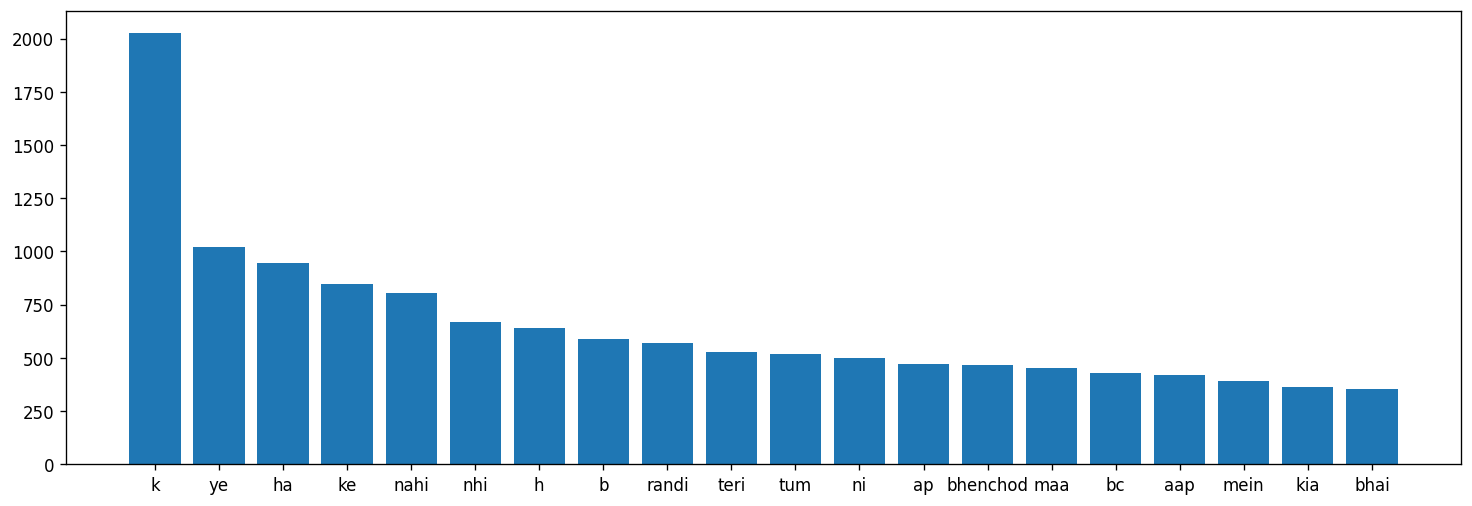

In [50]:
plt.rcParams['figure.figsize'] = [15,5]
plt.bar(top20_words.index,top20_words.values)

In [51]:
Least20_words = frequency_of_words[-20:]

<BarContainer object of 20 artists>

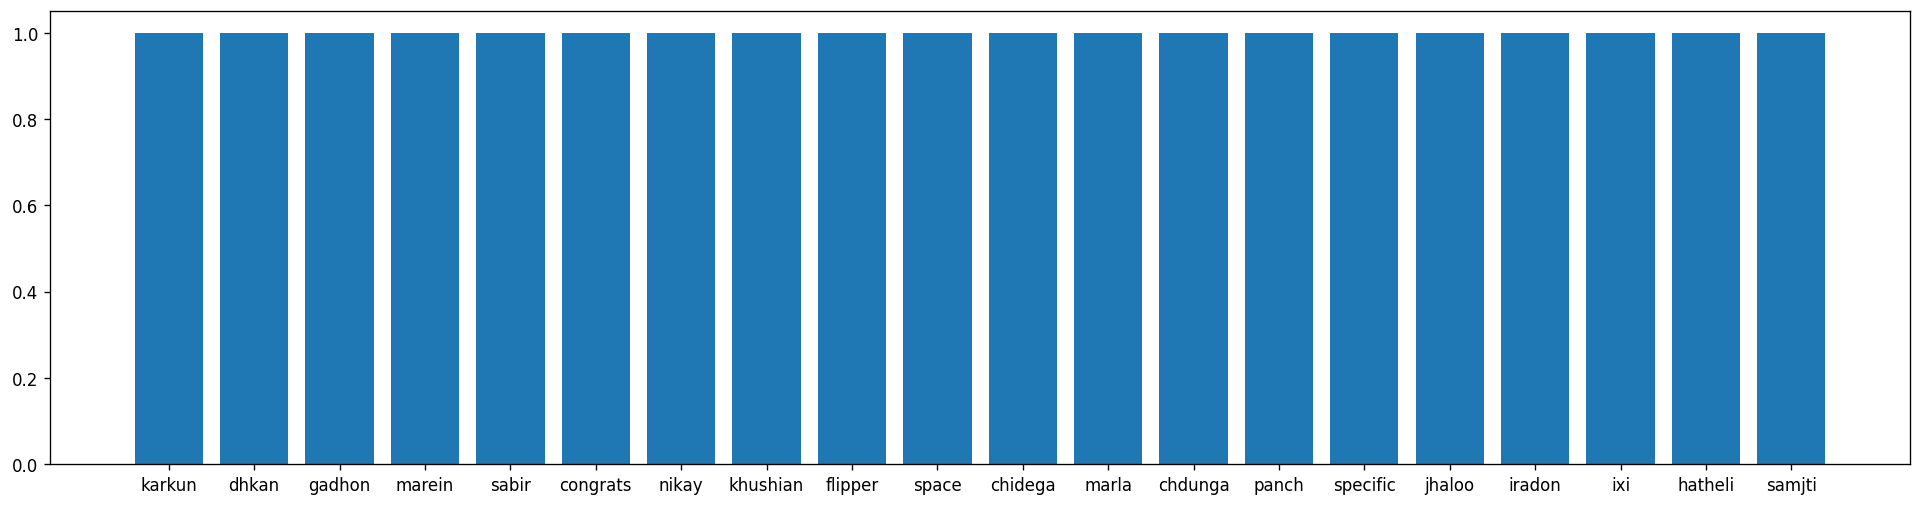

In [52]:
plt.rcParams['figure.figsize'] = [20,5]
plt.bar(Least20_words.index,Least20_words.values)

##Word Cloud

In [53]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
from wordcloud import WordCloud

In [55]:
abusive_tweets = get_value_counts(df_for_eda[df_for_eda['Label']==0],'clean_tweet')
abusive_tweets = ' '.join(abusive_tweets.index)

In [56]:
wordcloud_abusive = WordCloud(width = 800, height = 800,
                background_color ='black',
                max_font_size = 100).generate(abusive_tweets)

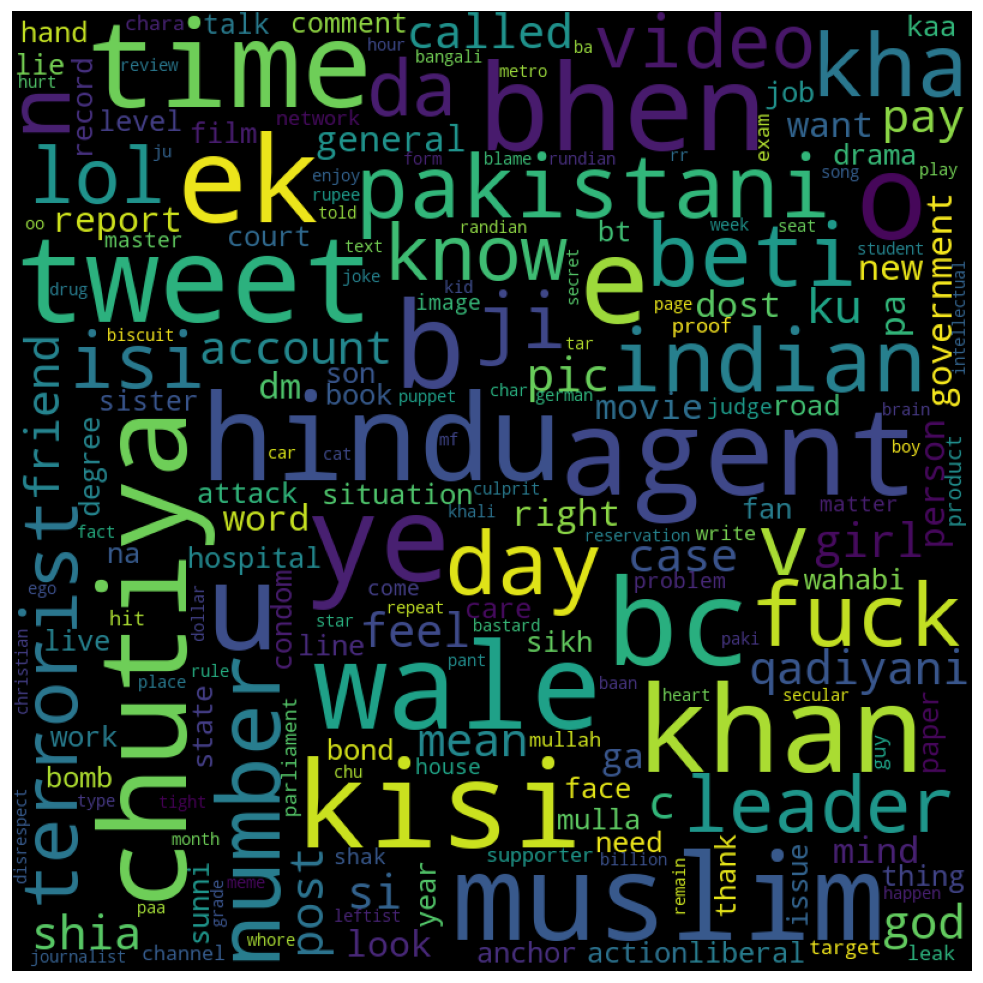

In [57]:
# plot the WordCloud image                      
plt.figure(figsize = (15, 8), facecolor = None)
plt.imshow(wordcloud_abusive)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [58]:
neutral_tweets = get_value_counts(df_for_eda[df_for_eda['Label']==1],'clean_tweet')
neutral_tweets = ' '.join(neutral_tweets.index)

In [59]:
wordcloud_neutral = WordCloud(width = 800, height = 800,
                background_color ='black',
                max_font_size = 100).generate(neutral_tweets)

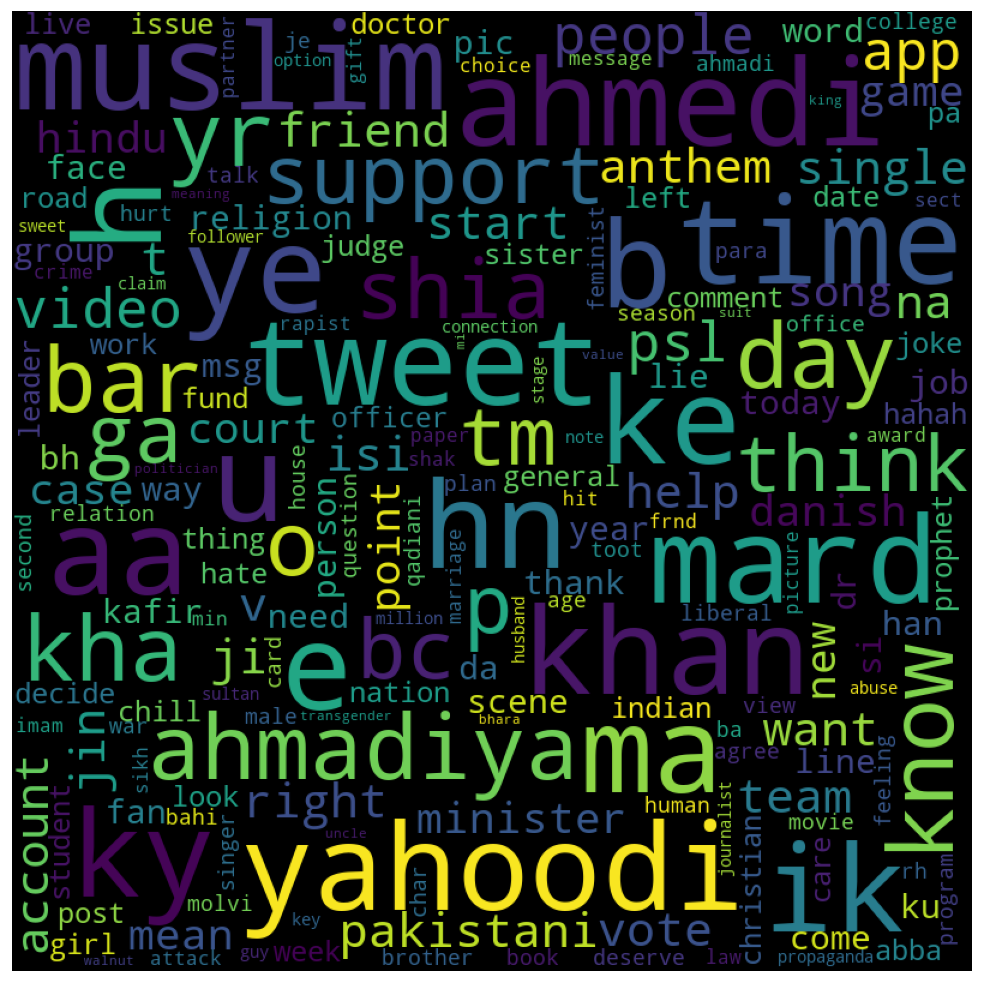

In [60]:
# plot the WordCloud image                      
plt.figure(figsize = (15, 8), facecolor = None)
plt.imshow(wordcloud_neutral)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Saving Cleaned and Preprocessed Data

In [61]:
df_for_eda.to_csv("Cleaned_data.csv")

# Model Building

In [62]:
df_for_eda.head()

,Tweet,Label,char_counts,word_counts,avg_wordlength,hashtag_counts,mentions_counts,digits_counts,clean_tweet
0,pichwara se akhrot kahe fod rahe ho chicha,1,35,8,4.375000,0,0,0,pichwara akhrot kahe fod rahe chicha
1,bhaunk bhaunk ke pagal ho jaata ab tak....,0,35,8,4.375000,0,0,1,bhaunk bhaunk ke pagal jaata tak
2,shivsaina nam mulla saina rakh hijra uddh...,0,46,8,5.750000,0,0,0,shivsaina nam mulla saina rakh hijra uddhav th...
3,there are some yahodi daboo like imran chore z...,0,47,10,4.700000,0,0,0,yahodi daboo like imran chore zakat khore
4,"chutiye ye hunduism ni he islam he , isme koi ...",0,69,18,3.833333,0,0,1,chutiye ye hunduism ni islam isme kisi muslim ...


In [63]:
text = df_for_eda['clean_tweet']
y = df_for_eda['Label']

## Machine Learning

### Tf-IDF Vectorization

As machine learnng algorithms only works on numeric data and we have to convert our data into vectors so i am converting the data into numeric vectors using TF IDF vectors

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

Total Number of tweets are 9212, and total features calculated with TF-IDF are 20920

In [66]:
X.shape

(9212, 20920)

X is basically a sparse matrix having more column values as zero and less values as 1

In [67]:
X

<9212x20920 sparse matrix of type '<class 'numpy.float64'>'
	with 95448 stored elements in Compressed Sparse Row format>

### Train Test dataset splitting 

In [68]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0,stratify=y)

In [69]:
from sklearn.metrics import confusion_matrix


In [70]:
def run_classifier(clf,X_train,y_train,X_test,y_test):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)

  print("Classification Report")
  print(classification_report(y_test,y_pred))

  print("Confusion Matrix")
  plt.rcParams['figure.figsize'] = [8,5]
  
  cm = confusion_matrix(y_test,y_pred)
  print(cm)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
  
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['Hate Speech', 'Neutral']); ax.yaxis.set_ticklabels(['Hate Speech', 'Neutral']);


In [71]:
def check_custom_user_input(x,clf):
  custom_x = remove_stop_words(x)
  custom_x = get_clean(custom_x)
  result = clf.predict(tfidf.transform([custom_x]))
  if result == 0:
    contenct_is = "Abusive/Offensive"
  else:
    contenct_is = "Normal/Neutral"
  print(f"Tweet: {x}\nPredicted Label:{contenct_is}")

### Linear SVM with TF-IDF

In [72]:
from sklearn import svm

In [73]:
lin_clf = svm.LinearSVC()

Achieved the F1 Score of **88%** on the Test dataset

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1073
           1       0.86      0.93      0.89      1230

    accuracy                           0.88      2303
   macro avg       0.88      0.87      0.88      2303
weighted avg       0.88      0.88      0.88      2303

Confusion Matrix
[[ 880  193]
 [  91 1139]]


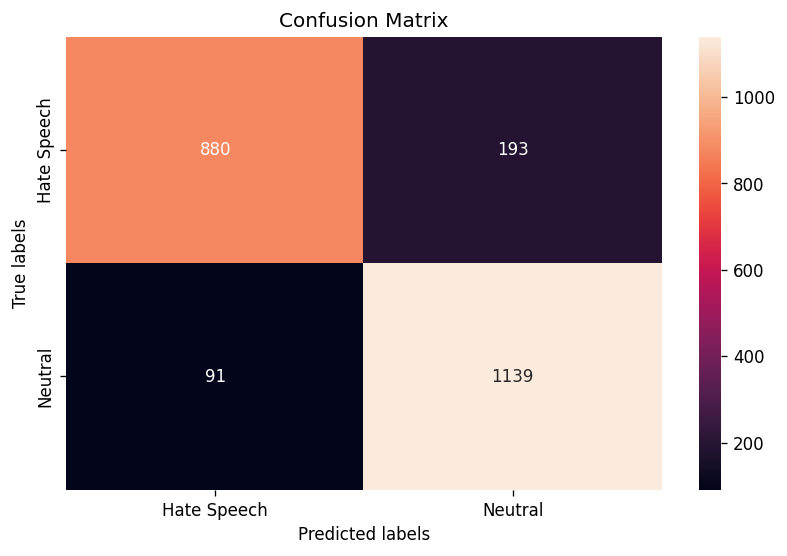

In [74]:
run_classifier(lin_clf,X_train,y_train,X_test,y_test)

#### Prediction on Custom Data

In [75]:
# Non Abusive tweet
x = "yr sahe baat b kr leta hai banda"
check_custom_user_input(x,lin_clf)

Tweet: yr sahe baat b kr leta hai banda
Predicted Label:Normal/Neutral


In [76]:
# Non Abusive tweet
x = "Chutiye samaj rahay ho kia"
check_custom_user_input(x,lin_clf)

Tweet: Chutiye samaj rahay ho kia
Predicted Label:Abusive/Offensive


## Deep Learning

In [129]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout,LSTM
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

In [79]:
text = df_for_eda['clean_tweet']
y = df_for_eda['Label']

### Converting text into tokens

In [81]:
token = Tokenizer()
token.fit_on_texts(text)

In [83]:
vocab_size = len(token.word_index) + 1
print(f"Vocabulary size of the tweet data is {vocab_size}")

Vocabulary size of the tweet data is 20956


In [84]:
print(token.word_index)

{'k': 1, 'ye': 2, 'ha': 3, 'ke': 4, 'nahi': 5, 'nhi': 6, 'h': 7, 'b': 8, 'randi': 9, 'teri': 10, 'tum': 11, 'ni': 12, 'ap': 13, 'bhenchod': 14, 'maa': 15, 'bc': 16, 'aap': 17, 'mein': 18, 'kia': 19, 'bhai': 20, 'apni': 21, 'baap': 22, 'pakistan': 23, 'kisi': 24, 'sab': 25, 'baat': 26, 'yahoodi': 27, 'ek': 28, 'pata': 29, 'ma': 30, 'tere': 31, 'log': 32, 'toh': 33, 'aurat': 34, 'allah': 35, 'yahodi': 36, 's': 37, 'chod': 38, 'meri': 39, 'hn': 40, 'khud': 41, 'mai': 42, 'hijra': 43, 'kiya': 44, 'e': 45, 'sath': 46, 'm': 47, 'dekh': 48, 'phir': 49, 'din': 50, 'akhrot': 51, 'kon': 52, 'bhen': 53, 'bharwe': 54, 'bat': 55, 'hoga': 56, 'apne': 57, 'khan': 58, 'imran': 59, 'aik': 60, 'tera': 61, 'mat': 62, 'jab': 63, 'hoti': 64, 'mera': 65, 'halala': 66, 'bhaunk': 67, 'lo': 68, 'q': 69, 'har': 70, 'karo': 71, 'pr': 72, 'di': 73, 'rahe': 74, 'hu': 75, 'nt': 76, 'kro': 77, 'u': 78, 'aa': 79, 'dil': 80, 'sirf': 81, 'abhi': 82, 'bol': 83, 'kam': 84, 'kay': 85, 'pta': 86, 'hua': 87, 'agar': 88, 'ta

In [85]:
# Converting text to sequences of numbers
encoded_text = token.texts_to_sequences(text)

In [87]:
print(encoded_text)

[[4250, 51, 1892, 5641, 74, 8602], [67, 67, 4, 335, 1504, 89], [8603, 446, 1505, 8604, 511, 43, 8605, 4251], [36, 1678, 92, 59, 322, 395, 498], [266, 2, 8606, 12, 146, 1383, 24, 115, 12, 5642, 113, 4, 429], [109, 1893, 45, 3422, 44, 3423, 756, 3424, 170, 847, 756, 4252, 61, 22, 170, 1278, 8607, 4252], [642, 8608, 799, 4253, 476, 723, 1279, 32, 5643, 1280, 990, 61, 147, 348, 597, 990, 31, 5644, 336, 180, 368, 200, 121, 8609, 7, 8610, 11, 2862, 310, 256, 16], [24, 6], [34, 2462, 8611, 529, 15, 12, 3425, 2, 757, 3426, 4254, 101, 146, 2463, 349, 3427, 991, 1045, 8612, 34, 530, 758, 2863, 4255, 5645, 4255, 2864], [2, 28, 5646, 1679, 8613, 85, 1894, 8614, 8615, 8616, 1, 46, 889, 2865, 11, 8617, 5, 181, 1110, 18, 11, 560, 8618, 848, 342, 18, 155, 4256, 3428, 8619], [3429, 2464, 260, 3430], [800, 96, 34, 133, 2, 4257, 1111, 75, 759], [65, 189, 39, 206, 1680, 8620, 236, 2151, 206, 8621, 171, 430, 2866, 5647, 760, 148, 1681], [356, 97, 8, 104, 8622, 62, 8623, 2465, 801, 1191, 1384, 3431], [337, 

Now we have to check that what is max lenght of tweets according to words, so we will pad the text to max length of the tweet so that while training our model keeps the lenght of the tweet in consideration and there is no chance of data leakage

In [88]:
# from the eda we can see that max length of tweet according to word count is 71 
#so to be on the safe side i am giving max lenght to pad equals to 40 word
max_length = 40
X = pad_sequences(encoded_text,maxlen=max_length,padding='post')

In [89]:
X.shape

(9212, 40)

In [90]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0,stratify=y)

### Experiment # 1 with CNN

In [92]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size,vec_size,input_length=max_length))

model.add(Conv1D(32,2,activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16,activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1,activation="sigmoid"))

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           2095600   
                                                                 
 conv1d (Conv1D)             (None, 39, 32)            6432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 32)            0         
                                                                 
 dense (Dense)               (None, 19, 32)            1056      
                                                                 
 dropout_1 (Dropout)         (None, 19, 32)            0         
                                                        

In [96]:
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [98]:
checkpoint_filepath = '/content/Model_Checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [99]:
history_cnn = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),callbacks=[model_checkpoint_callback])

Epoch 1/10
216/216 [==============================] - 11s 42ms/step - loss: 0.5230 - accuracy: 0.7490 - val_loss: 0.3828 - val_accuracy: 0.8558
Epoch 2/10
216/216 [==============================] - 9s 40ms/step - loss: 0.2541 - accuracy: 0.9046 - val_loss: 0.3066 - val_accuracy: 0.8771
Epoch 3/10
216/216 [==============================] - 9s 41ms/step - loss: 0.1211 - accuracy: 0.9582 - val_loss: 0.3626 - val_accuracy: 0.8693
Epoch 4/10
216/216 [==============================] - 9s 41ms/step - loss: 0.0556 - accuracy: 0.9834 - val_loss: 0.4619 - val_accuracy: 0.8589
Epoch 5/10
216/216 [==============================] - 9s 41ms/step - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.5126 - val_accuracy: 0.8615
Epoch 6/10
216/216 [==============================] - 9s 42ms/step - loss: 0.0197 - accuracy: 0.9936 - val_loss: 0.5826 - val_accuracy: 0.8602
Epoch 7/10
216/216 [==============================] - 9s 41ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.6189 - val_accuracy: 0.856

### Experiment # 2 with LSTM

In [131]:
model_lstm=Sequential()

model_lstm.add(Embedding(vocab_size,vec_size,input_length=max_length))

model_lstm.add(LSTM(128,input_shape=(X_train.shape),activation='relu',return_sequences=True))

model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(128,activation='relu'))

model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(32,activation='relu'))

model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(1,activation='sigmoid'))

model_lstm.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

print(model_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 100)           2095600   
                                                                 
 lstm_2 (LSTM)               (None, 40, 128)           117248    
                                                                 
 dropout_5 (Dropout)         (None, 40, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dropout_7 (Dropout)         (None, 32)               

In [132]:
checkpoint_filepath = '/content/Model_Checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [135]:
history_lstm = model_lstm.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),callbacks=[model_checkpoint_callback])

Epoch 1/10
216/216 [==============================] - 36s 151ms/step - loss: 7.7998 - accuracy: 0.5500 - val_loss: 0.6861 - val_accuracy: 0.5341
Epoch 2/10
216/216 [==============================] - 32s 150ms/step - loss: 0.9649 - accuracy: 0.5992 - val_loss: 0.6418 - val_accuracy: 0.6435
Epoch 3/10
216/216 [==============================] - 32s 148ms/step - loss: 0.6621 - accuracy: 0.6299 - val_loss: 100.1674 - val_accuracy: 0.6717
Epoch 4/10
216/216 [==============================] - 32s 150ms/step - loss: 44.3086 - accuracy: 0.6371 - val_loss: 0.6723 - val_accuracy: 0.5788
Epoch 5/10
216/216 [==============================] - 32s 150ms/step - loss: 3.5161 - accuracy: 0.6927 - val_loss: 122.5521 - val_accuracy: 0.4416
Epoch 6/10
216/216 [==============================] - 32s 150ms/step - loss: 17.9567 - accuracy: 0.5607 - val_loss: 0.6830 - val_accuracy: 0.5528
Epoch 7/10
216/216 [==============================] - 32s 150ms/step - loss: 0.6743 - accuracy: 0.5693 - val_loss: 0.6715 - 

# Custom Input check how model performs

In [ ]:
def check_custom_user_input(x,clf):
  custom_x = remove_stop_words(x)
  custom_x = get_clean(custom_x)
  result = clf.predict(tfidf.transform([custom_x]))
  if result == 0:
    contenct_is = "Abusive/Offensive"
  else:
    contenct_is = "Normal/Neutral"
  print(f"Tweet: {x}\nPredicted Label:{contenct_is}")

In [121]:
def custom_data_preprocess(x):
  custom_x = remove_stop_words(x)  
  custom_x = get_clean(custom_x)
  custom_x = token.texts_to_sequences([custom_x])
  custom_x = pad_sequences(custom_x,maxlen=max_length,padding="post")
  return custom_x

def predict_tweet_sentiment(x):
  vec = custom_data_preprocess(x)
  result = model.predict(vec)

  if result >= 0.5:
    contenct_is = "Normal"
  else:
    contenct_is = "Abusive"
  print(f"Tweet: {x}\nPredicted Label:{contenct_is}")

In [126]:
# Non Abusive tweet
x = " haha...yh dusri sense m tha"
predict_tweet_sentiment(x)

Tweet:  haha...yh dusri sense m tha
Predicted Label:Normal


In [128]:
# Abusive tweet
x = " chal bey kutty teraaa baaap men hun... tu mri wo galti he jisy soch k khyaal ataa"
predict_tweet_sentiment(x)

Tweet:  chal bey kutty teraaa baaap men hun... tu mri wo galti he jisy soch k khyaal ataa
Predicted Label:Abusive
